In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score
from xgboost import XGBClassifier

from cinnamon.drift import ModelDriftExplainer, AdversarialDriftExplainer

# config
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

seed = 2021

# IEEE fraud data

Download data with kaggle CLI if it is setup on your computer:

In [2]:
#!kaggle competitions download -c ieee-fraud-detection

Else you can download the data here: https://www.kaggle.com/c/ieee-fraud-detection/data, and you will have to accept the competition rules

In [3]:
df = pd.read_csv('data/train_transaction.csv')

In [4]:
print(df.shape)

(590540, 394)


# Preprocessing

In [5]:
# count missing values per column
missing_values = df.isnull().sum(axis=0)
missing_values

TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               8933
card3               1565
card4               1577
card5               4259
card6               1571
addr1              65706
addr2              65706
dist1             352271
dist2             552913
P_emaildomain      94456
R_emaildomain     453249
C1                     0
C2                     0
C3                     0
C4                     0
C5                     0
C6                     0
C7                     0
C8                     0
C9                     0
C10                    0
C11                    0
C12                    0
C13                    0
C14                    0
D1                  1269
D2                280797
D3                262878
D4                168922
D5                309841
D6                517353
D7                551623
D8                515614
D9                515614


In [6]:
# keep only columns with less than 10000 values
selected_columns = [col for col in df.columns if missing_values[col] < 10000]

In [7]:
# in the resulting columns, drop rows with any missing value
df = df[selected_columns].dropna(axis=0, how='any')

INFO:2022-05-26 21:24:28,135 - (/opt/anaconda3/lib/python3.8/site-packages/numexpr/utils.py) Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:2022-05-26 21:24:28,136 - (/opt/anaconda3/lib/python3.8/site-packages/numexpr/utils.py) NumExpr defaulting to 8 threads.


In [8]:
# for the variable 'card6', keep only rows corresponding to 'debit' and 'credit'modalities
df = df.loc[df['card6'].isin(['debit', 'credit']), :].copy()
df['card6'] = (df['card6'] == 'credit') * 1

In [9]:
df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,0,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,1.0,48.0,28.0,0.0,10.0,4.0,1.0,38.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,50.0,1758.0,925.0,0.0,354.0,135.0,50.0,1404.0,790.0,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,0.0,10.0,0.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2987005,0,86510,49.0,W,5937,555.0,150.0,visa,226.0,0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Sampling

We replicate a typical production situation where we would have:
- training data
- test data
- production data

Also, we introduce so data drift on the variable `card6` by using downsampling. This data drift corresponds to covariate shift.

In [10]:
# select features by keeping only numerical features
features = [col for col in df.columns if col not in ['TransactionID', 'isFraud', 'TransactionDT',
                                                     'ProductCD', 'card4']]

In [11]:
# we do a time split (shuffle=False) to seperate between df_temp (train-test data) and df_prod (production data)
df_temp, df_prod = train_test_split(df.copy(), test_size=0.25, shuffle=False, random_state=seed)

In [12]:
df_temp['card6'].value_counts()

0    322580
1    110956
Name: card6, dtype: int64

In [13]:
# in df_temp, we downsample the modality '0' to introduce covariate shift
# (distribution before and after sampling are given in cell above and below)
np.random.seed(seed)
df_temp = df_temp.loc[((np.random.randint(low=0, high=9, size=df_temp.shape[0]) == 0) |
                       (df_temp['card6'].values == 1)), :]

In [14]:
df_temp['card6'].value_counts()

1    110956
0     35496
Name: card6, dtype: int64

In [15]:
# we do a time split (shuffle=False) to seperate between training data and test data
X_train, X_test, y_train, y_test = train_test_split(df_temp[features].copy(),
                                                      df_temp['isFraud'].values,
                                                      test_size=1/3,
                                                      shuffle=False,
                                                      random_state=seed)

In [16]:
X_prod, y_prod = df_prod[features], df_prod['isFraud'].values

# Build model

In [17]:
clf = XGBClassifier(n_estimators=1000,
                    booster="gbtree",
                    objective="binary:logistic",
                    learning_rate=0.2,
                    max_depth=6,
                    use_label_encoder=False,
                    seed=seed)

In [18]:
clf.fit(X=X_train, y=y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=20,
        verbose=10, eval_metric=['auc', 'logloss'])

[0]	validation_0-auc:0.80389	validation_0-logloss:0.54097
[10]	validation_0-auc:0.86533	validation_0-logloss:0.17737
[20]	validation_0-auc:0.88529	validation_0-logloss:0.15301
[30]	validation_0-auc:0.89251	validation_0-logloss:0.15012
[40]	validation_0-auc:0.89516	validation_0-logloss:0.14930
[50]	validation_0-auc:0.89393	validation_0-logloss:0.15027
[56]	validation_0-auc:0.89354	validation_0-logloss:0.15085


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=12, num_parallel_tree=1,
              random_state=2021, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=2021, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

# Detection of data drift

We do detect a data drift in this case. Our three indicators:
- distribution of predictions
- distribution of target labels
- performance metrics

show a data drift

In [19]:
# initialize and fit a model drift explainer on test and prod data
drift_explainer = ModelDriftExplainer(clf)
drift_explainer.fit(X1=X_test, X2=X_prod, y1=y_test, y2=y_prod)

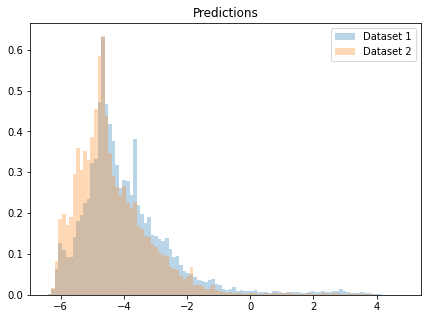

[DriftMetricsNum(mean_difference=-0.4263138365739074, wasserstein=0.4263140925240701, ks_test=BaseStatisticalTestResult(statistic=0.1570079426762936, pvalue=0.0))]

In [20]:
drift_explainer.plot_prediction_drift(bins=100)
drift_explainer.get_prediction_drift()

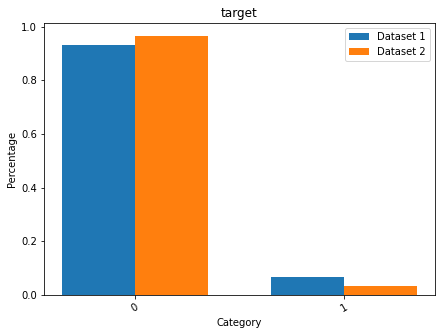

DriftMetricsCat(wasserstein=0.03204989433375958, jensen_shannon=0.0521196934251732, chi2_test=Chi2TestResult(statistic=916.6450502479124, pvalue=2.362780443914502e-201, dof=1, contingency_table=           0       1
X1   45565.0  3253.0
X2  139514.0  4998.0))

In [21]:
drift_explainer.plot_target_drift()
drift_explainer.get_target_drift()

In [22]:
print(f'log_loss test: {log_loss(y_test, clf.predict_proba(X_test))}')
print(f'log_loss prod: {log_loss(y_prod, clf.predict_proba(X_prod))}')

log_loss test: 0.14929075483219717
log_loss prod: 0.10625483017844635


# Explaination of data drift

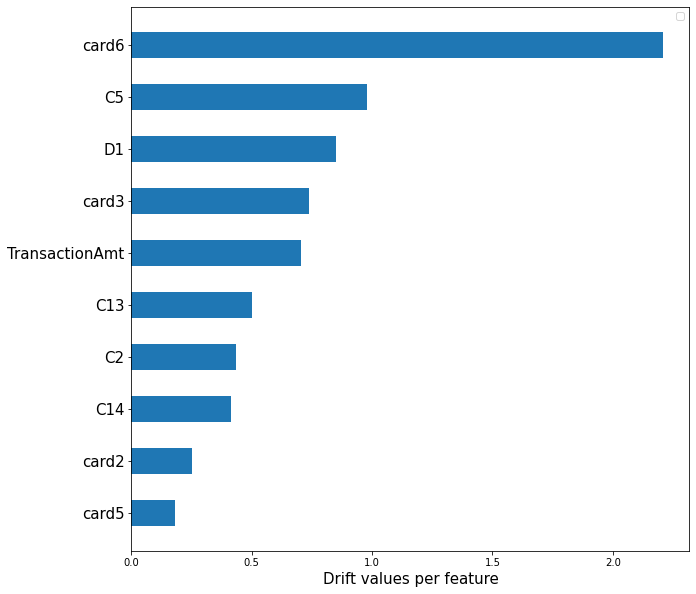

In [23]:
# plot drift values in order to identify features that have the higher impacts on data drift
drift_explainer.plot_tree_based_drift_values(type='node_size')

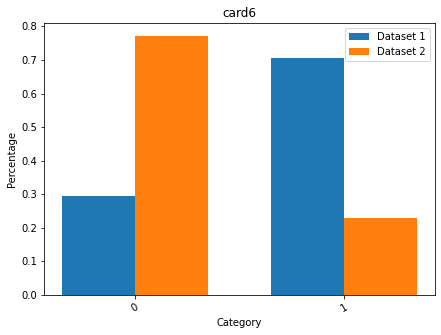

In [ ]:
# first drift value feature is 'card6' : the one we voluntarily add drift to.
drift_explainer.plot_feature_drift('card6', as_discrete=True)
drift_explainer.get_feature_drift('card6')

In [ ]:
# feature importance of the model
# interestingly, 'card6' feature is quite far in the list of impartant feature in the model
pd.DataFrame(clf.feature_importances_, X_train.columns).sort_values(0, ascending=False)

In [ ]:
drift_explainer.plot_feature_drift('C5')
drift_explainer.get_feature_drift('C5')

In [ ]:
drift_explainer.plot_feature_drift('TransactionAmt')
drift_explainer.get_feature_drift('TransactionAmt')

# Correction of data drift

## Correction on test dataset

We apply our methodology which uses adversarial learning to correct data drift between test and prod data.

We then check our three indicators of  data drift in order to see if we get improvement.

In [ ]:
# weights computed with the adversarial method
# feature_subset=['card6']: only the first feature in terms of drift value is selected here
sample_weights_test_adversarial = (AdversarialDriftExplainer(feature_subset=['card6'], seed=2021)
                                    .fit(X_test, X_prod)
                                    .get_adversarial_correction_weights(max_ratio=10))

In [ ]:
# study the drift with the new weights on test data
drift_explainer2 = ModelDriftExplainer(clf)
drift_explainer2.fit(X1=X_test, X2=X_prod, y1=y_test, y2=y_prod,
                     sample_weights1=sample_weights_test_adversarial)

In [ ]:
# with new weigts on test data, distributions of predictions are much closer
drift_explainer2.plot_prediction_drift(bins=100)
drift_explainer2.get_prediction_drift()

In [ ]:
# distribution of target if also corrected
drift_explainer2.plot_target_drift()
drift_explainer2.get_target_drift()

In [ ]:
# we now replicates much better what happens in production (also in terms of log loss)
print(f'log_loss test: {log_loss(y_test, clf.predict_proba(X_test), sample_weight=sample_weights_test_adversarial)}')
print(f'log_loss prod: {log_loss(y_prod, clf.predict_proba(X_prod))}')

## Correction on validation dataset and train dataset (in order to retrain the model)

We apply the same adversarial strategy on training data.

With the new weights, we observe the model trained on re-weighted does not seem to perform better than the model trained on non-weighted data.

In [ ]:
# weights computed with the adversarial method on training data
sample_weights_train_adversarial = (AdversarialDriftExplainer(feature_subset=['card6'], seed=2021, verbosity=False)
                                    .fit(X_train, X_prod)
                                    .get_adversarial_correction_weights(max_ratio=10))

In [ ]:
clf2 = XGBClassifier(n_estimators=1000,
                    booster="gbtree",
                    objective="binary:logistic",
                    learning_rate=0.2,
                    max_depth=5,
                    use_label_encoder=False,
                    seed=seed)

In [ ]:
# train a new classifier with the reweighted samples
clf2.fit(X=X_train, y=y_train, eval_set=[(X_test, y_test)], sample_weight=sample_weights_train_adversarial,
         early_stopping_rounds=20, verbose=10, eval_metric=['auc', 'logloss'],
         sample_weight_eval_set=[sample_weights_test_adversarial])

In [ ]:
# we see no improvement on prod loss when we train with both train and test datasets reweighted
print(f'log_loss test: {log_loss(y_test, clf2.predict_proba(X_test), sample_weight=sample_weights_test_adversarial)}')
print(f'log_loss prod: {log_loss(y_prod, clf2.predict_proba(X_prod))}')